In [95]:
import pickle
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
from time import time
from scipy import sparse
from sklearn import linear_model
from sklearn import preprocessing
# Library to be able to use bow
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
# from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# library to be able to use gnb
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.externals import joblib
import os.path

In [96]:
def feature_selection(features, target):
 
    chi2_features = chi2(features, target) 
    umbral = chi2_features[1] > 0.85
    count = 0

    for i, item in enumerate(umbral):
        if item:
            count = count + 1  
    return count

In [102]:
def tfidf_vectorizer(X):
    vectorizer = TfidfVectorizer(min_df=3, max_features=10000, norm='l2',
                                     use_idf=True, smooth_idf=True, ngram_range=([1, 1]))
    X = vectorizer.fit_transform(X).toarray()  
    
    return X

In [103]:
def tfidf_chi2_lr_clf(X,y):
    
    chi2_selector = SelectKBest(chi2, k=feature_selection(X_train,y_train))
    clf = linear_model.LogisticRegression( penalty='l2', C=50,random_state=0)
    p = Pipeline([('vect', chi2_selector), ('clf', clf)])
    p = p.fit(X_train, y_train)
    
    return p

In [104]:
def predict_pipeline_OVA(pipeline, X_test, y_test):

    y_pred = pipeline.predict(X_test)
    #y_test = lb.inverse_transform(y_test)
    my_tags = pipeline.classes_

    evaluate_prediction(y_pred, y_test)
    precision_recall_f1(y_test, y_pred)
    
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    print(
        'Correctly Classifed {0} out of {1}'.format(accuracy_score(target, predictions, normalize=False), len(target)))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')
    print('(row=expected, col=predicted)')
    
   
        
        

def precision_recall_f1(y_test, y_pred):
    print('\nmacro')
    p, r, f, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_pred, average='macro')
    print('Precision: {0:0.3f}, Recall : {1:0.3f}, F1: {2:0.4f}'.format(p, r, f))

    print('\nmicro')
    p, r, f, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_pred, average='micro')
    print('Precision: {0:0.3f}, Recall : {1:0.3f}, F1: {2:0.4f}'.format(p, r, f))

    print('\nweighted')
    p, r, f, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_pred, average='weighted')
    print('Precision: {0:0.3f}, Recall : {1:0.3f}, F1: {2:0.4f}'.format(p, r, f))

    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)

    accuracy = np.average(recall)
    
    print('\nprecision: {}'.format(precision))
    print('\nrecall: {}'.format(recall))
    print('\nfscore: {}'.format(fscore))
    print('\nsupport: {}'.format(support))
    print('\nACC:{}'.format(accuracy))
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))    
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=90)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def save_classifer(obj, obj_name):
    pickle.dump(obj, open(obj_name, 'wb'))


def load_classifier(obj_name):
    return pickle.load(open(obj_name, 'rb'))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy 0.9768041237113402
Correctly Classifed 1516 out of 1552
confusion matrix
 [[1070    5]
 [  31  446]]
(row=expected, col=predicted)

macro
Precision: 0.980, Recall : 0.965, F1: 0.9723

micro
Precision: 0.977, Recall : 0.977, F1: 0.9768

weighted
Precision: 0.977, Recall : 0.977, F1: 0.9766

precision: [0.97184378 0.98891353]

recall: [0.99534884 0.93501048]

fscore: [0.98345588 0.9612069 ]

support: [1075  477]

ACC:0.9651796596947979


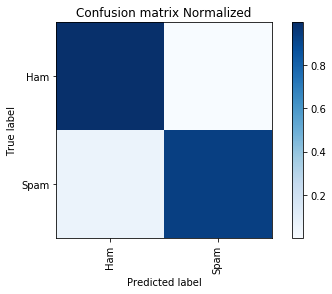

In [105]:
data_frame = pd.read_csv("enronText.csv")

lb = preprocessing.LabelBinarizer()

X = data_frame['Text'].astype(str)
y = data_frame['Category'].astype(str)

my_tags = ['Ham','Spam']

X = tfidf_vectorizer(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = tfidf_chi2_lr_clf(X_train,y_train)

predict_pipeline_OVA(clf, X_test, y_test)